In [95]:
import csv
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import os
import glob
import cmcrameri.cm as cmc

from pygments.lexer import default
from streamlit import title

In [96]:
h = 6.62606957 * 10 **(-34)
c0 = 299792458
charge = 1.602176565 * 10 ** (-19)
thickness = 1 * 10 **(-5)

In [132]:
def zero_remover(data): #Only for lists
    zero_removed_data = []
    for i in range(0,len(data)):
        if data[i] > 0:
            zero_removed_data.append(data[i])
        else:
            zero_removed_data.append(0)
    zero_removed_data = np.array(zero_removed_data)
    return zero_removed_data

def csv_to_numpy(csv_file):
    all_data = genfromtxt(csv_file,delimiter=",",dtype=float, missing_values=["NaN", "#DIV/0!"], filling_values=0)
    all_data_removed_headers = all_data[2:,:]
    #cleaned_data = np.where(all_data_removed_headers > 0, all_data_removed_headers, 0)
    return all_data_removed_headers

def seperated_data(clean_data):
    wavelength = np.array(clean_data[:,0])
    transmission0 = np.array(clean_data[:,1])
    transmission100 = np.array(clean_data[:,2])
    BA2PbI4 = np.array(clean_data[:,3])
    SC_BA2MAPb2I7 = np.array(clean_data[:,4])
    PC_BA2MAPb2I7 = np.array(clean_data[:,5])

    energy_J = h * c0 / (wavelength * (10 **(-9)))
    energy_eV = energy_J * charge
    incident = transmission100 - transmission0
    BA2PbI4_background = BA2PbI4 - transmission0
    SC_BA2MAPb2I7_background = SC_BA2MAPb2I7 - transmission0
    PC_BA2MAPb2I7_background = PC_BA2MAPb2I7 - transmission0
    return energy_eV, wavelength, incident, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background

In [133]:
#Load in the data
directory = r"A:\Y4 Project code\Data\PL Raw data"
# Use glob to find all CSV files (recursively if needed)
csv_files = glob.glob(os.path.join(directory, "*.csv"))

data_dict = {}

for file in csv_files:
    key = os.path.splitext(os.path.basename(file))[0]
    #print(key)
    key = key.replace("PL easy acces data - ", "", 1) #format == key.replace("old bit of key", "new bit of key", "counts(if counts == 1 then replaces all instances)")
    #print(key)

    hours = key.split("h")[0].strip()
    #print(hours)
    #print(hours, "hours")
    #minutes = int(short_key.split("h")[1].strip()) if len(short_key) > 1 and short_key.split("h")[1].strip() else 0
    #print(minutes, "minutes")
    #if minutes > 30:
        #hours = hours + 1

    #print(short_key)
    #print(key)
    data_dict[str(hours)] = csv_to_numpy(file)
print(data_dict.keys())
#print(data_dict["0"][:, 0])
#print(data_dict["0"][:, 1])
#print(data_dict["0"][:, 2])
#print(data_dict["0"][:, 3])
#print(data_dict["0"][:, 4])
#print(data_dict["0"][:, 5])

#the order of the keys is in the awful ['0', '139', '162', '167', '185', '192', '1', '209', '21', '215', '26', '44', '50', '67', '73'] order. We need to fix that
key_list = []
key_sort = []
for key in data_dict.keys():
    key_list.append(key)
    key_sort.append(float(key))

correct_key_order = np.argsort(key_sort)
print(correct_key_order)


correct_keys = []

for key in correct_key_order:
    correct_keys.append(key_list[key])


new_dict = {}

for key in correct_keys:
    new_dict[str(key)] = data_dict[str(key)]
data_dict = new_dict
print(data_dict.keys()) #viola!

dict_keys(['0.5', '0', '1.5', '1', '2.5', '26', '2', '3.5', '3', '4.5', '4'])
[ 1  0  3  2  6  4  8  7 10  9  5]
dict_keys(['0', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '26'])


In [177]:
#functions to make the plots look a lot neater
def text_and_plot_stuff(figsize=(10,20), line_width=4, font_size=28, i=0):
    plt.rcParams.update({
        "font.size": font_size,
        "axes.titlesize": font_size+4,
        "axes.labelsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size-4
    })

    fig, ax = plt.subplots(figsize=figsize)
    #if i == 3 or i == 5:
        #fig, ax = plt.subplots(figsize=figsize)
    #elif i == 4:
        #fig, ax = plt.subplots(figsize=(10,30))

    ax.axes.yaxis.set_ticklabels([])
    ax.tick_params(axis='both', width=line_width, length=20)
    ax.tick_params(axis='both', which='minor', length=10, width=line_width)

    for spine in ["bottom", "left", "top", "right"]:
        ax.spines[spine].set_linewidth(line_width)

    plt.grid(which='major', axis="y", linewidth=line_width)
    plt.grid(which='minor', axis="y", linewidth=line_width/4)
    plt.grid(which='major', axis="x", linewidth=line_width)
    plt.grid(which='minor', axis="x", linewidth=line_width/4)
    return fig, ax

def set_y_ticks(ax, y_jumps):
    # cumulative boundaries: 0, y1, y1+y2, y1+y2+y3, ...
    major_positions = np.concatenate(([0], np.cumsum(y_jumps)))
    levels = len(y_jumps)

    # major ticks get the usual "0"
    ax.set_yticks(major_positions, ["0"] * (levels + 1))

    # fractions for minor ticks inside each block
    fractions = [0.25, 0.5, 0.75]

    minor_positions = []
    minor_labels = []

    for idx, jump in enumerate(y_jumps):
        start = major_positions[idx]
        for f in fractions:
            minor_positions.append(start + f * jump)
            minor_labels.append(format(f * jump, ".2g"))

    ax.set_yticks(minor_positions, minor_labels, minor=True)

def add_scale_bars(ax, x_pos, y_jumps, color="red", line_width=4, x_displace=10, unit=""):
    cum = np.concatenate(([0], np.cumsum(y_jumps)))
    levels = len(y_jumps)

    for idx, jump in enumerate(y_jumps):
        y_center = cum[idx] + jump / 2
        ax.errorbar(
            x=x_pos,
            y=y_center,
            yerr=jump / 2,
            capsize=10,
            linewidth=line_width / 2,
            markeredgewidth=2,
            color=color,
            label="_nolegend_",
        )
        ax.text(x_pos + x_displace, y_center, f"{jump} {unit}", va='center', label="_nolegend_")

def legend_setup():
    handles, labels = plt.gca().get_legend_handles_labels()
    neatened_labels = np.char.rstrip(labels, 'h').astype(float)
    order = np.argsort(neatened_labels)
    return handles, labels, order


In [178]:
#funciton for the photoluminescence data
def seperated_data(clean_data):
    wavelength = np.array(clean_data[:,0])
    transmission0 = np.array(clean_data[:,1])
    #transmission100 = np.array(clean_data[:,2])
    BA2PbI4 = np.array(clean_data[:,3])
    SC_BA2MAPb2I7 = np.array(clean_data[:,4])
    PC_BA2MAPb2I7 = np.array(clean_data[:,5])

    energy_J = h * c0 / (wavelength * (10 **(-9)))
    energy_eV = energy_J * charge
    #incident = transmission100 - transmission0
    BA2PbI4_background = BA2PbI4 - transmission0
    SC_BA2MAPb2I7_background = SC_BA2MAPb2I7 - transmission0
    PC_BA2MAPb2I7_background = PC_BA2MAPb2I7 - transmission0
    return energy_eV, wavelength, BA2PbI4_background, SC_BA2MAPb2I7_background, PC_BA2MAPb2I7_background

def PL_Plot(colour_index, key, key_index, dictionary, i=0):
    ev, wavelength, BA2PbI4, SC, PC  = seperated_data(dictionary[key])
    if i == 3:
        PL = BA2PbI4
    elif i == 4:
        PL = SC
    elif i == 5:
        PL = PC

    index_add_value = key_index
    #indexed_PL = index_add_value + PL
    cmap = plt.cm.viridis
    colour = cmap(colour_index)
    plt.plot(wavelength, PL, label= f"{key}h", color=colour, linewidth=2)
    return

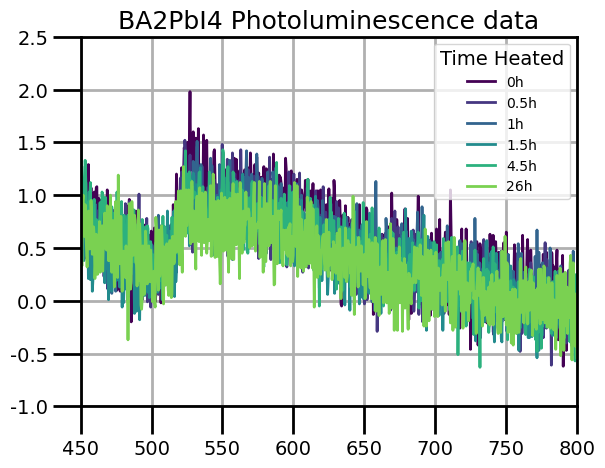

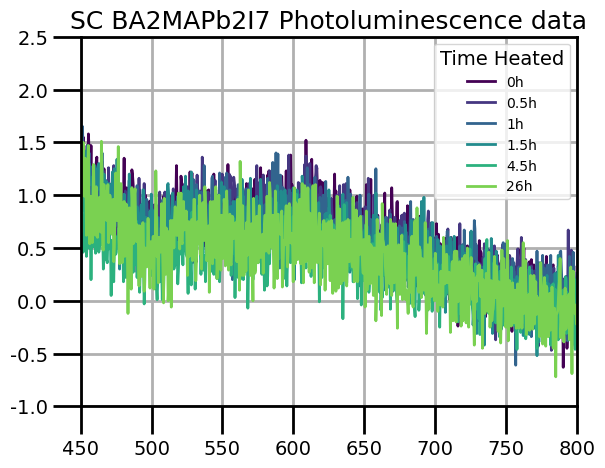

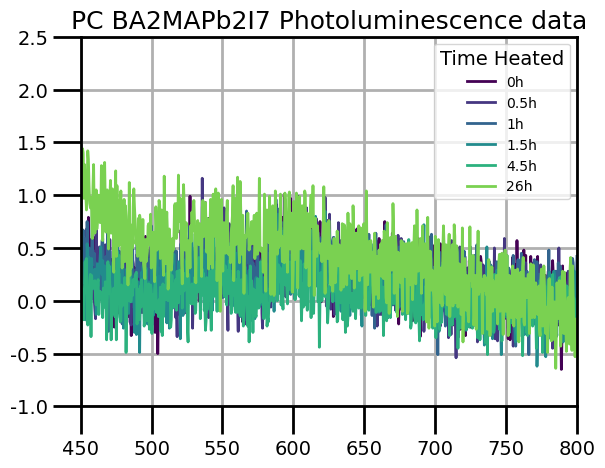

In [194]:
def thing(nth_plot=0, i=0, y_max = 2.5,y_min=-1, plots=[]):
    colour_index = (nth_plot-1) / (len(plots)-1) * 0.8
    cmap = plt.cm.viridis
    colour = cmap(colour_index)

    ev, wavelength, BA2PbI4, SC, PC = seperated_data(data_dict[key])

    if i == 3:
        PL = BA2PbI4
    elif i == 4:
        PL = SC
    elif i == 5:
        PL = PC

    plt.plot(wavelength, PL, label=f"{key}h", color=colour, linewidth=2)
    plt.legend(title="Time Heated")
    plt.ylim(y_min, y_max)
    plt.xlim(450, 800)
    y_ticks = np.linspace(y_min, y_max, 8)
    ax.set_yticks(y_ticks, [f"{y_ticks[i]}" for i in range(len(y_ticks))])

    #minor_y_ticks = np.linspace(0, y_max, 5)
    #print(minor_y_ticks)

    name = {3:"BA2PbI4", 4:"SC BA2MAPb2I7", 5:"PC BA2MAPb2I7"}[i]
    plt.title(f"{name} Photoluminescence data")

times_not_to_plot=[4, 5, 6, 7, 8]
for i in [3, 4, 5]:
    nth_plot = 0
    fig, ax = text_and_plot_stuff(figsize=None, line_width=2, font_size=14, i=0)
    for key_index, key in enumerate(data_dict):
        if key_index in times_not_to_plot:
            continue
        valid_plots = [key for key_index, key in enumerate(data_dict) if key_index not in times_not_to_plot]
        nth_plot += 1
        thing(nth_plot=nth_plot, i=i, y_max=2.5, plots=valid_plots)
    plt.show()